In [0]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
import numpy as np
import time

from datetime import date
import pandas as pd
import holidays
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt

In [0]:
# set up storage
blob_container = "container1" # The name of your container created in https://portal.azure.com
storage_account = "w261sec6group3" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261sec6group3_scope" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261sec6group3_key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
df_final = spark.read.parquet(f"{blob_url}/final_feature_eng")

In [0]:
df_final.display()

quarter month day_of_month day_of_week fl_date op_unique_carrier op_carrier_airline_id op_carrier tail_num op_carrier_fl_num origin_airport_id origin_airport_seq_id origin_city_market_id origin origin_city_name origin_state_abr origin_state_fips origin_state_nm origin_wac dest_airport_id dest_airport_seq_id dest_city_market_id dest dest_city_name dest_state_abr dest_state_fips dest_state_nm dest_wac crs_dep_time dep_time dep_delay dep_delay_new dep_del15 dep_delay_group dep_time_blk taxi_out wheels_off wheels_on taxi_in crs_arr_time arr_time arr_delay arr_delay_new arr_del15 arr_delay_group arr_time_blk cancelled diverted crs_elapsed_time actual_elapsed_time air_time flights distance distance_group div_airport_landings year IATA station_id name icao lat lon altitude station_lon station_lat timezone type crs_dep_hour flight_hour flight_time flight_time_utc flight_time_utc_hour flight_time_utc_year flight_time_utc_month flight_time_utc_date is_holiday weather_station weather_station_name metar_hour avg_hourly_dew_point_temp avg_hourly_dry_bulb_temp avg_hourly_relative_humidity avg_hourly_station_pressure avg_hourly_visibility avg_hourly_wind_direction avg_hourly_wind_speed avg_hourly_precipitation_ordinal pagerank avg_hourly_dew_point_temp_lag6 avg_hourly_dry_bulb_temp_lag6 avg_hourly_relative_humidity_lag6 avg_hourly_station_pressure_lag6 avg_hourly_visibility_lag6 avg_hourly_wind_direction_lag6 avg_hourly_wind_speed_lag6 avg_hourly_precipitation_ordinal_lag6 avg_hourly_dew_point_temp_lag12 avg_hourly_dry_bulb_temp_lag12 avg_hourly_relative_humidity_lag12 avg_hourly_station_pressure_lag12 avg_hourly_visibility_lag12 avg_hourly_wind_direction_lag12 avg_hourly_wind_speed_lag12 avg_hourly_precipitation_ordinal_lag12 arr_del15_lag1 origin_lag1 frequent_delay total_flights 1 1 1 4 2015-01-01 B6 20409 B6 N663JB 951 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 1553 1706 73.0 73.0 1.0 4 1500-1559 23.0 1729 2015 3.0 1919 2018 59.0 59.0 1.0 3 1900-1959 0.0 0.0 206.0 192.0 166.0 1.0 1121.0 5 0 2015 BOS 72509014739 General Edward Lawrence Logan International Airport KBOS 42.36429977 -71.00520325 20 -71.01 42.361 America/New_York large_airport 15.0 1553 2015-01-01T15:53:00.000+0000 2015-01-01T20:53:00.000+0000 20 2015 1 1 1 72509014739 BOSTON, MA US 2015-01-01T17:00:00.000+0000 9.0 30.0 41.0 29.899999618530273 10.0 230.0 16.0 0.0 5.0 7.0 33.0 33.0 29.899999618530273 10.0 210.0 16.0 0.0 6.0 25.0 44.0 30.059999465942383 10.0 240.0 16.0 0.0 0.0 TPA 2 446585 1 1 18 7 2015-01-18 B6 20409 B6 N510JB 451 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 1100 1053 -7.0 0.0 0.0 -1 1100-1159 11.0 1104 1407 3.0 1426 1410 -16.0 0.0 0.0 -2 1400-1459 0.0 0.0 206.0 197.0 183.0 1.0 1121.0 5 0 2015 BOS 72509014739 General Edward Lawrence Logan International Airport KBOS 42.36429977 -71.00520325 20 -71.01 42.361 America/New_York large_airport 11.0 1100 2015-01-18T11:00:00.000+0000 2015-01-18T16:00:00.000+0000 16 2015 1 18 1 72509014739 BOSTON, MA US 2015-01-18T13:00:00.000+0000 42.5 47.5 82.5 29.920000076293945 10.0 175.0 7.5 0.0 5.0 34.0 38.0 86.0 30.020000457763672 10.0 0.0 0.0 0.0 18.0 23.0 81.0 30.18000030517578 10.0 150.0 5.0 0.0 0.0 MCO 2 446585 1 1 16 5 2015-01-16 B6 20409 B6 N508JB 51 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 721 711 -10.0 0.0 0.0 -1 0700-0759 13.0 724 1005 11.0 1047 1016 -31.0 0.0 0.0 -2 1000-1059 0.0 0.0 206.0 185.0 161.0 1.0 1121.0 5 0 2015 BOS 72509014739 General Edward Lawrence Logan International Airport KBOS 42.36429977 -71.00520325 20 -71.01 42.361 America/New_York large_airport 7.0 0721 2015-01-16T07:21:00.000+0000 2015-01-16T12:21:00.000+0000 12 2015 1 16 1 72509014739 BOSTON, MA US 2015-01-16T09:00:00.000+0000 19.0 31.0 61.0 29.709999084472656 10.0 230.0 10.0 0.0 5.0 14.0 22.0 71.0 29.700000762939453 10.0 220.0 9.0 0.0 12.0 26.0 55

# Airport Size

In [0]:
df_final.createOrReplaceTempView("final_eda")
df = sqlContext.sql("""SELECT type, 
    AVG(dep_delay) AVG_DEP_DEL,
    SUM (DEP_DEL15)/COUNT(1)*100 DEP_DEL15_PERCENT
    FROM final_eda group by type""")

In [0]:
df.display()

type AVG_DEP_DEL DEP_DEL15_PERCENT large_airport 9.79118390390735 17.619608016494006 medium_airport 8.180561290417195 14.84166354937978 small_airport 9.512875898612846 15.650361921474007

In [0]:
df_final.display()

quarter month day_of_month day_of_week fl_date op_unique_carrier op_carrier_airline_id op_carrier tail_num op_carrier_fl_num origin_airport_id origin_airport_seq_id origin_city_market_id origin origin_city_name origin_state_abr origin_state_fips origin_state_nm origin_wac dest_airport_id dest_airport_seq_id dest_city_market_id dest dest_city_name dest_state_abr dest_state_fips dest_state_nm dest_wac crs_dep_time dep_time dep_delay dep_delay_new dep_del15 dep_delay_group dep_time_blk taxi_out wheels_off wheels_on taxi_in crs_arr_time arr_time arr_delay arr_delay_new arr_del15 arr_delay_group arr_time_blk cancelled diverted crs_elapsed_time actual_elapsed_time air_time flights distance distance_group div_airport_landings year IATA station_id name icao lat lon altitude station_lon station_lat timezone type crs_dep_hour flight_hour flight_time flight_time_utc flight_time_utc_hour flight_time_utc_year flight_time_utc_month flight_time_utc_date is_holiday weather_station weather_station_name metar_hour avg_hourly_dew_point_temp avg_hourly_dry_bulb_temp avg_hourly_relative_humidity avg_hourly_station_pressure avg_hourly_visibility avg_hourly_wind_direction avg_hourly_wind_speed avg_hourly_precipitation_ordinal pagerank avg_hourly_dew_point_temp_lag6 avg_hourly_dry_bulb_temp_lag6 avg_hourly_relative_humidity_lag6 avg_hourly_station_pressure_lag6 avg_hourly_visibility_lag6 avg_hourly_wind_direction_lag6 avg_hourly_wind_speed_lag6 avg_hourly_precipitation_ordinal_lag6 avg_hourly_dew_point_temp_lag12 avg_hourly_dry_bulb_temp_lag12 avg_hourly_relative_humidity_lag12 avg_hourly_station_pressure_lag12 avg_hourly_visibility_lag12 avg_hourly_wind_direction_lag12 avg_hourly_wind_speed_lag12 avg_hourly_precipitation_ordinal_lag12 arr_del15_lag1 origin_lag1 frequent_delay total_flights 1 1 1 4 2015-01-01 B6 20409 B6 N663JB 951 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 1553 1706 73.0 73.0 1.0 4 1500-1559 23.0 1729 2015 3.0 1919 2018 59.0 59.0 1.0 3 1900-1959 0.0 0.0 206.0 192.0 166.0 1.0 1121.0 5 0 2015 BOS 72509014739 General Edward Lawrence Logan International Airport KBOS 42.36429977 -71.00520325 20 -71.01 42.361 America/New_York large_airport 15.0 1553 2015-01-01T15:53:00.000+0000 2015-01-01T20:53:00.000+0000 20 2015 1 1 1 72509014739 BOSTON, MA US 2015-01-01T17:00:00.000+0000 9.0 30.0 41.0 29.899999618530273 10.0 230.0 16.0 0.0 5.0 7.0 33.0 33.0 29.899999618530273 10.0 210.0 16.0 0.0 6.0 25.0 44.0 30.059999465942383 10.0 240.0 16.0 0.0 0.0 TPA 2 446585 1 1 18 7 2015-01-18 B6 20409 B6 N510JB 451 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 1100 1053 -7.0 0.0 0.0 -1 1100-1159 11.0 1104 1407 3.0 1426 1410 -16.0 0.0 0.0 -2 1400-1459 0.0 0.0 206.0 197.0 183.0 1.0 1121.0 5 0 2015 BOS 72509014739 General Edward Lawrence Logan International Airport KBOS 42.36429977 -71.00520325 20 -71.01 42.361 America/New_York large_airport 11.0 1100 2015-01-18T11:00:00.000+0000 2015-01-18T16:00:00.000+0000 16 2015 1 18 1 72509014739 BOSTON, MA US 2015-01-18T13:00:00.000+0000 42.5 47.5 82.5 29.920000076293945 10.0 175.0 7.5 0.0 5.0 34.0 38.0 86.0 30.020000457763672 10.0 0.0 0.0 0.0 18.0 23.0 81.0 30.18000030517578 10.0 150.0 5.0 0.0 0.0 MCO 2 446585 1 1 16 5 2015-01-16 B6 20409 B6 N508JB 51 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 721 711 -10.0 0.0 0.0 -1 0700-0759 13.0 724 1005 11.0 1047 1016 -31.0 0.0 0.0 -2 1000-1059 0.0 0.0 206.0 185.0 161.0 1.0 1121.0 5 0 2015 BOS 72509014739 General Edward Lawrence Logan International Airport KBOS 42.36429977 -71.00520325 20 -71.01 42.361 America/New_York large_airport 7.0 0721 2015-01-16T07:21:00.000+0000 2015-01-16T12:21:00.000+0000 12 2015 1 16 1 72509014739 BOSTON, MA US 2015-01-16T09:00:00.000+0000 19.0 31.0 61.0 29.709999084472656 10.0 230.0 10.0 0.0 5.0 14.0 22.0 71.0 29.700000762939453 10.0 220.0 9.0 0.0 12.0 26.0 55

# Previous Delay Flight

In [0]:
df_final = df_final.na.drop(subset='arr_del15_lag1')

df_final.createOrReplaceTempView("final_eda")
df_previous_delay = sqlContext.sql("""SELECT arr_del15_lag1, 
    AVG(dep_delay) AVG_DEP_DEL,
    SUM (DEP_DEL15)/COUNT(1)*100 DEP_DEL15_PERCENT
    FROM final_eda group by arr_del15_lag1""")

In [0]:
df_previous_delay.display()

arr_del15_lag1 AVG_DEP_DEL DEP_DEL15_PERCENT 0.0 3.5548900558806937 9.782479954073874 1.0 36.79002390910548 52.193206237025315

In [0]:
df_previous_delay = df_previous_delay.toPandas()

In [0]:
nodelay_delay = df_previous_delay['DEP_DEL15_PERCENT'][0]
delay_delay = df_previous_delay['DEP_DEL15_PERCENT'][1]

Out[25]:

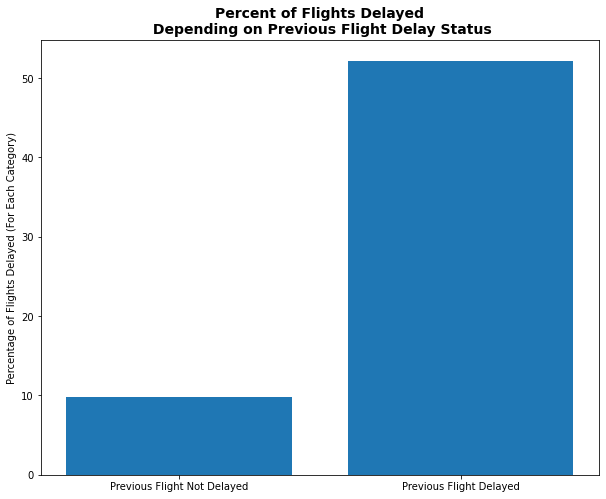

Text(0.5, 1.0, 'Percent of Flights Delayed\n Depending on Previous Flight Delay Status')

In [0]:
x_labels = ['Previous Flight Not Delayed', 'Previous Flight Delayed']
y = [nodelay_delay, delay_delay]

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x=x_labels, height=y)
ax.set_ylabel('Percentage of Flights Delayed (For Each Category)')
ax.set_title('Percent of Flights Delayed\n Depending on Previous Flight Delay Status', fontsize=14, fontweight='bold')

# Holiday

In [0]:
df_final.createOrReplaceTempView("final_eda")
df = sqlContext.sql("""SELECT if(is_holiday=0, 'not holiday', 'is_holiday') as is_holiday, 
    AVG(dep_delay) AVG_DEP_DEL,
    SUM (DEP_DEL15)/COUNT(1)*100 DEP_DEL15_PERCENT
    FROM final_eda group by is_holiday""")

In [0]:
df.display()

is_holiday AVG_DEP_DEL DEP_DEL15_PERCENT is_holiday 9.894530800792975 17.710697236759305 not holiday 9.486606046504482 17.283473430612396

In [0]:
df.display()

is_holiday AVG_DEP_DEL DEP_DEL15_PERCENT is_holiday 9.894530800792975 17.710697236759305 not holiday 9.626403935193554 17.346889634275357

# Flight Frequency

In [0]:
df_final.display()

quarter month day_of_month day_of_week fl_date op_unique_carrier op_carrier_airline_id op_carrier tail_num op_carrier_fl_num origin_airport_id origin_airport_seq_id origin_city_market_id origin origin_city_name origin_state_abr origin_state_fips origin_state_nm origin_wac dest_airport_id dest_airport_seq_id dest_city_market_id dest dest_city_name dest_state_abr dest_state_fips dest_state_nm dest_wac crs_dep_time dep_time dep_delay dep_delay_new dep_del15 dep_delay_group dep_time_blk taxi_out wheels_off wheels_on taxi_in crs_arr_time arr_time arr_delay arr_delay_new arr_del15 arr_delay_group arr_time_blk cancelled diverted crs_elapsed_time actual_elapsed_time air_time flights distance distance_group div_airport_landings year IATA station_id name icao lat lon altitude station_lon station_lat timezone type crs_dep_hour flight_hour flight_time flight_time_utc flight_time_utc_hour flight_time_utc_year flight_time_utc_month flight_time_utc_date is_holiday weather_station weather_station_name metar_hour avg_hourly_dew_point_temp avg_hourly_dry_bulb_temp avg_hourly_relative_humidity avg_hourly_station_pressure avg_hourly_visibility avg_hourly_wind_direction avg_hourly_wind_speed avg_hourly_precipitation_ordinal pagerank avg_hourly_dew_point_temp_lag6 avg_hourly_dry_bulb_temp_lag6 avg_hourly_relative_humidity_lag6 avg_hourly_station_pressure_lag6 avg_hourly_visibility_lag6 avg_hourly_wind_direction_lag6 avg_hourly_wind_speed_lag6 avg_hourly_precipitation_ordinal_lag6 avg_hourly_dew_point_temp_lag12 avg_hourly_dry_bulb_temp_lag12 avg_hourly_relative_humidity_lag12 avg_hourly_station_pressure_lag12 avg_hourly_visibility_lag12 avg_hourly_wind_direction_lag12 avg_hourly_wind_speed_lag12 avg_hourly_precipitation_ordinal_lag12 arr_del15_lag1 origin_lag1 frequent_delay total_flights 1 1 1 4 2015-01-01 B6 20409 B6 N663JB 951 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 1553 1706 73.0 73.0 1.0 4 1500-1559 23.0 1729 2015 3.0 1919 2018 59.0 59.0 1.0 3 1900-1959 0.0 0.0 206.0 192.0 166.0 1.0 1121.0 5 0 2015 BOS 72509014739 General Edward Lawrence Logan International Airport KBOS 42.36429977 -71.00520325 20 -71.01 42.361 America/New_York large_airport 15.0 1553 2015-01-01T15:53:00.000+0000 2015-01-01T20:53:00.000+0000 20 2015 1 1 1 72509014739 BOSTON, MA US 2015-01-01T17:00:00.000+0000 9.0 30.0 41.0 29.899999618530273 10.0 230.0 16.0 0.0 5.0 7.0 33.0 33.0 29.899999618530273 10.0 210.0 16.0 0.0 6.0 25.0 44.0 30.059999465942383 10.0 240.0 16.0 0.0 0.0 TPA 2 446585 1 1 18 7 2015-01-18 B6 20409 B6 N510JB 451 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 1100 1053 -7.0 0.0 0.0 -1 1100-1159 11.0 1104 1407 3.0 1426 1410 -16.0 0.0 0.0 -2 1400-1459 0.0 0.0 206.0 197.0 183.0 1.0 1121.0 5 0 2015 BOS 72509014739 General Edward Lawrence Logan International Airport KBOS 42.36429977 -71.00520325 20 -71.01 42.361 America/New_York large_airport 11.0 1100 2015-01-18T11:00:00.000+0000 2015-01-18T16:00:00.000+0000 16 2015 1 18 1 72509014739 BOSTON, MA US 2015-01-18T13:00:00.000+0000 42.5 47.5 82.5 29.920000076293945 10.0 175.0 7.5 0.0 5.0 34.0 38.0 86.0 30.020000457763672 10.0 0.0 0.0 0.0 18.0 23.0 81.0 30.18000030517578 10.0 150.0 5.0 0.0 0.0 MCO 2 446585 1 1 16 5 2015-01-16 B6 20409 B6 N508JB 51 10721 1072102 30721 BOS Boston, MA MA 25 Massachusetts 13 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 721 711 -10.0 0.0 0.0 -1 0700-0759 13.0 724 1005 11.0 1047 1016 -31.0 0.0 0.0 -2 1000-1059 0.0 0.0 206.0 185.0 161.0 1.0 1121.0 5 0 2015 BOS 72509014739 General Edward Lawrence Logan International Airport KBOS 42.36429977 -71.00520325 20 -71.01 42.361 America/New_York large_airport 7.0 0721 2015-01-16T07:21:00.000+0000 2015-01-16T12:21:00.000+0000 12 2015 1 16 1 72509014739 BOSTON, MA US 2015-01-16T09:00:00.000+0000 19.0 31.0 61.0 29.709999084472656 10.0 230.0 10.0 0.0 5.0 14.0 22.0 71.0 29.700000762939453 10.0 220.0 9.0 0.0 12.0 26.0 55

In [0]:
from pyspark.sql.functions import *

In [0]:
df_final.createOrReplaceTempView('test')

test = sqlContext.sql('''
    SELECT flight_time_utc_year, month, DATE_FORMAT(FL_DATE, 'MMyyyy') as month_year, AVG(total_flights) AS total_flights
    FROM test
    GROUP BY flight_time_utc_year, month, month_year
    ORDER BY flight_time_utc_year, month, month_year
''')

In [0]:
test.display()

flight_time_utc_year month month_year total_flights 2015 1 012015 446585.0 2015 2 022015 446356.7001279203 2015 3 032015 401420.8760944608 2015 4 042015 484239.12963824836 2015 5 052015 472624.87993268337 2015 6 062015 482531.45708896185 2015 7 072015 486802.8142504143 2015 8 082015 505941.6530849168 2015 9 092015 496257.8160026342 2015 10 102015 455729.7068032494 2015 11 112015 477508.3971704737 2015 12 122015 454630.0 2016 1 012016 462837.0641325659 2016 2 022016 425569.0680443772 2016 3 032016 405989.03432865045 2016 4 042016 465315.7896859315 2016 5 052016 449199.96984505845 2016 6 062016 467196.46639192145 2016 7 072016 473259.86242909223 2016 8 082016 482431.5630740891 2016 9 092016 482321.82377030776 2016 10 102016 445507.2195193097 2016 11 112016 459853.0152817271 2016 12 122015 463120.0 2016 12 122016 439255.0 2017 1 012017 446438.4129432394 2017 2 022017 429936.0029764234 2017 3 032017 396268.07416717045 2017 4 042017 471751.0389469689 2017 5 052017 453357.5226516606 2017 6 062017 473459.9909922698 2017 7 072017 478486.7137679252 2017 8 082017 494191.5082833526 2017 9 092017 489518.89800099214 2017 10 102017 436623.58393405774 2017 11 112017 467513.1724029578 2017 12 122016 446549.0 2017 12 122017 440721.0 2018 1 012018 451083.3755124686 2018 2 022018 544221.7609054524 2018 3 032018 505345.2428381358 2018 4 042018 587181.1404458306 2018 5 052018 576944.5844833179 2018 6 062018 600998.9543024864 2018 7 072018 606269.7881718344 2018 8 082018 623205.2366747019 2018 9 092018 622500.6560100791 2018 10 102018 558978.5849687228 2018 11 112018 604548.361423702 2018 12 122017 450392.0 2018 12 122018 569935.0 2019 1 012019 578317.170614079 2019 2 022019 557297.4783581448 2019 3 032019 511521.25515178574 2019 4 042019 612315.6294188879 2019 5 052019 590232.702861228 2019 6 062019 614999.0091123412 2019 7 072019 616811.5176272608 2019 8 082019 634609.2747891947 2019 9 092019 640013.6466510735 2019 10 102019 585569.3806203349 2019 11 112019 621482.3652544966 2019 12 122018 578469.0 2019 12 122019 585673.0 2020 1 012020 612814.710526138 2020 2 022020 590280.4933930261 2020 3 032020 563656.3533202662 2020 4 042020 527749.5582822425 2020 5 052020 181993.9624526228 2020 6 062020 166832.465816649 2020 7 072020 220242.0083664681 2020 8 082020 344843.5573741564 2020 9 092020 368078.8964083804 2020 10 102020 319157.6597122988 2020 11 112020 346731.31070207566 2020 12 122019 612992.0 2020 12 122020 354827.0 2021 1 012021 363468.243289233 2021 2 022021 350926.4593820101 2021 3 032021 309035.9891398159 2021 4 042021 431337.77979861747 2021 5 052021 440486.7398393473 2021 6 062021 483622.4536538039 2021 7 072021 527745.688684452 2021 8 082021 563467.1855197885 2021 9 092021 552364.0239149588 2021 10 102021 520784.09814156214 2021 11 112021 543747.9801732316 2021 12 122020 363549.0 2021 12 122021 533244.0 2022 12 122021 530380.0

In [0]:
df_final.createOrReplaceTempView('final')

df_month_year = sqlContext.sql('''
    SELECT flight_time_utc_year, month, AVG(total_flights) AS total_flights
    FROM final
    GROUP BY flight_time_utc_year, month
    ORDER BY flight_time_utc_year, month
''')

In [0]:
df_month_year = df_month_year.toPandas()

In [0]:
month_year_list = []

for year in [2015, 2016, 2017, 2018, 2019, 2020, 2021]:
    for month in range(1,13):
        month_year_list.append(str(year) + '-' + str(month))
        
month_year_list.append('2022-1')

Out[190]:

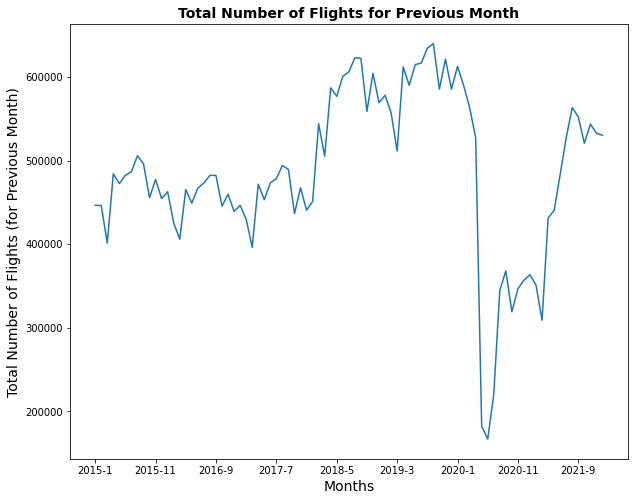

Text(0, 0.5, 'Total Number of Flights (for Previous Month)')

In [0]:
fig, ax = plt.subplots(figsize=(10,8))
plt.xticks(np.arange(0, 84, 10))
ax.plot(month_year_list, df_month_year.total_flights.to_list())
ax.set_title('Total Number of Flights for Previous Month', fontsize=14, fontweight='bold')
ax.set_xlabel('Months', fontsize=14)
ax.set_ylabel('Total Number of Flights (for Previous Month)', fontsize=14)

# Frequent Delayed Routes

In [0]:
df_final.createOrReplaceTempView("final_eda")
df_routes = sqlContext.sql(
    """SELECT if(frequent_delay=0, 'nonfrequent_delay', 'frequent_delay') AS is_holiday, 
    AVG(dep_delay) AVG_DEP_DEL,
    SUM (DEP_DEL15)/COUNT(1)*100 DEP_DEL15_PERCENT
    FROM final_eda group by is_holiday""")

Out[193]:

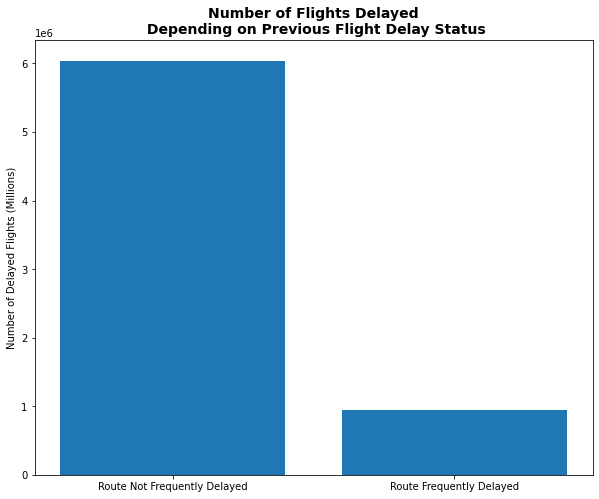

Text(0.5, 1.0, 'Number of Flights Delayed\n Depending on Previous Flight Delay Status')

In [0]:
x_labels = ['Route Not Frequently Delayed', 'Route Frequently Delayed']
y = [nonfrequent_delay, frequent_delay]

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(x=x_labels, height=y)
ax.set_ylabel('Number of Delayed Flights (Millions)')
ax.set_title('Number of Flights Delayed\n Depending on Previous Flight Delay Status', fontsize=14, fontweight='bold')